In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import h5py
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [2]:
image_files = Path('../input/food41/images')
images = list(image_files.glob(r'**/*.jpg'))
label = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], images))
imagedata = pd.DataFrame({'Files' : images, "label" : label}).astype(str).sample(frac = 1.0, random_state = 1).reset_index(drop=True)

category_samples = []
for category in imagedata['label'].unique():
    category_slice = imagedata.query('label== @category')
    category_samples.append(category_slice.sample(500, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state =1).reset_index(drop=True)

In [3]:
image_df

,Files,label
0,../input/food41/images/guacamole/1666970.jpg,guacamole
1,../input/food41/images/edamame/1734442.jpg,edamame
2,../input/food41/images/edamame/67807.jpg,edamame
3,../input/food41/images/fried_rice/3607245.jpg,fried_rice
4,../input/food41/images/seaweed_salad/852275.jpg,seaweed_salad
...,...,...
50495,../input/food41/images/club_sandwich/769843.jpg,club_sandwich
50496,../input/food41/images/churros/1750440.jpg,churros
50497,../input/food41/images/tacos/85137.jpg,tacos
50498,../input/food41/images/deviled_eggs/1235408.jpg,deviled_eggs


In [4]:
image_df['label'].value_counts()

ravioli                500
spaghetti_bolognese    500
pork_chop              500
tuna_tartare           500
sushi                  500
                      ... 
bibimbap               500
churros                500
greek_salad            500
creme_brulee           500
beignets               500
Name: label, Length: 101, dtype: int64

In [5]:
traindata, testdata = train_test_split(image_df, train_size =0.7, random_state =1)

In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input, validation_split=0.2)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input)

In [7]:
train_images = train_generator.flow_from_dataframe(
    dataframe=traindata,
    x_col='Files',
    y_col='label',
    target=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=True,
    subset ='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=traindata,
    x_col='Files',
    y_col='label',
    target=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=True,
    subset ='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=testdata,
    x_col='Files',
    y_col='label',
    target=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 28280 validated image filenames belonging to 101 classes.
Found 7070 validated image filenames belonging to 101 classes.
Found 15150 validated image filenames belonging to 101 classes.


In [8]:
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling = 'avg'        
) 

base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [13]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 101)              

In [14]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,verbose = 1)
early_stop = EarlyStopping(monitor = 'val_accuracy',patience = 3,verbose = 1,restore_best_weights = True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [15]:
history = model.fit(train_images, 
                    epochs=10,
                    validation_data = val_images,
                    callbacks=[early_stop, reduce_lr, model_checkpoint_callback])

Epoch 1/10
884/884 [==============================] - 189s 212ms/step - loss: 3.3517 - accuracy: 0.2269 - val_loss: 2.0430 - val_accuracy: 0.4696
Epoch 2/10
884/884 [==============================] - 178s 202ms/step - loss: 2.0080 - accuracy: 0.4749 - val_loss: 1.8625 - val_accuracy: 0.5144
Epoch 3/10
884/884 [==============================] - 182s 206ms/step - loss: 1.6997 - accuracy: 0.5513 - val_loss: 1.8222 - val_accuracy: 0.5296
Epoch 4/10
884/884 [==============================] - 178s 202ms/step - loss: 1.5358 - accuracy: 0.5875 - val_loss: 1.8095 - val_accuracy: 0.5345
Epoch 5/10
884/884 [==============================] - 179s 203ms/step - loss: 1.3557 - accuracy: 0.6296 - val_loss: 1.8144 - val_accuracy: 0.5434
Epoch 6/10
884/884 [==============================] - 181s 204ms/step - loss: 1.1758 - accuracy: 0.6743 - val_loss: 1.8284 - val_accuracy: 0.5426

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/10
884/884 [======================

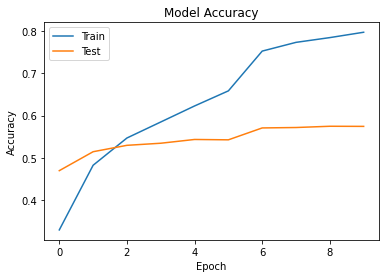

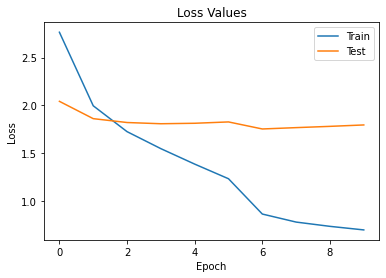

In [18]:
#Plotting Accuracy v/s Epochs
plt.figure(1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
#Plotting Loss v/s Epochs
plt.figure(2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Values')

plt.show()